In [5]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
from IPython.display import clear_output
from src.loading import *
from src.saving import *
from src.moisture_space import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Phase Composites

In [18]:
# Get files for raw data
#
variable = 'cli'
variable_files = get_raw_gsam_variable_files(variable)
# Get satfrac files
#
satfrac_files = get_daily_combined_2d_gsam_files()
assert(len(variable_files)==len(satfrac_files))

# Load PCs
#
pcs = load_gsam_eofs_pcs().scores()
pcs = pcs/pcs.std(('lat', 'lon', 'time'))
# Compute phase angle, phase number, and radius
# Where radius < 0.5, we set phase number to 0
#
theta = np.arctan2(pcs.sel(mode=2), pcs.sel(mode=1))
radius = np.sqrt(pcs.sel(mode=2)**2 + pcs.sel(mode=1)**2)
phase_num = theta.copy(data=np.floor(np.mod((np.array(theta)+(np.pi/8))/(np.pi/4) + 4, 8))+1)
phase_num = phase_num.where(radius > 0.5, other=0, drop=False)

# The extracted grids will be stored in a dictionary.
# Both the variable data and the saturation fraction will be kept
#
sorted_var_grids_by_phase = {f'phase{n}': [] for n in range(1, 9)}

for i, (vf, sff) in enumerate(zip(variable_files, satfrac_files)):
    clear_output()
    print(f'File {i+1} of {len(variable_files)}')
    var_ds = xr.open_dataset(vf)[variable]
    satfrac_ds = xr.open_dataset(sff)
    satfrac_ds = satfrac_ds['PW']/satfrac_ds['PWS']
    
    # Segment the data into grids
    #
    gridded_var = segment_data_into_grids(var_ds, patch_length=50)
    gridded_satfrac = segment_data_into_grids(satfrac_ds, patch_length=50)

    for phase in range(1, 9):
        # Identify which large-scale grids are in the desired phase
        #
        phase_mask = (phase_num.sel(time=gridded_var.time)==phase)
        (grid_time_idx, grid_lat_idx, grid_lon_idx) = np.where(phase_mask)
        phase_grids = [
            gridded_var
            .isel({'time': time_idx})
            .sel({'coarse_grid_lat': lat_idx, 'coarse_grid_lon': lon_idx})
            .stack(column=('lat', 'lon'))
            for (time_idx, lat_idx, lon_idx) in zip(grid_time_idx, grid_lat_idx, grid_lon_idx)
        ]
        
        phase_satfrac = [
            gridded_satfrac
            .isel({'time': time_idx})
            .sel({'coarse_grid_lat': lat_idx, 'coarse_grid_lon': lon_idx})
            .stack(column=('lat', 'lon'))
            for (time_idx, lat_idx, lon_idx) in zip(grid_time_idx, grid_lat_idx, grid_lon_idx)
        ]

        # Sort each grid by its sat frac values
        #
        sorted_var_grids_by_phase[f'phase{phase}'].extend(
            [ 
                grid
                .sortby(satfrac)
                .drop_vars(['column', 'lat', 'lon'])
                .assign_coords({'column': np.linspace(0, 1, grid.column.size)})
                for (grid, satfrac) in zip(phase_grids, phase_satfrac)
            ]
        )

# Composite the grids in each phase
# We compute
# - Composite: average over all data
# - Composite anomaly: average of anomalies for each grid
# - Composite mean: average of the averages (average large-scale profiles)
#
composite_grids = {phase: None for phase in sorted_var_grids_by_phase.keys()}
composite_anomaly_grids = {phase: None for phase in sorted_var_grids_by_phase.keys()}
composite_mean_grids = {phase: None for phase in sorted_var_grids_by_phase.keys()}

for phase, grids in sorted_var_grids_by_phase.items():
    print(f'Processing Phase {phase}')
    phase_grids = xr.concat(
        grids,
        dim=pd.Index(range(len(grids)), name='member')
    )
    
    phase_grid_means = phase_grids.mean('column')
    phase_grid_anoms = phase_grids - phase_grid_means
    composite_grids[phase] = phase_grids.mean('member')
    composite_mean_grids[phase] = phase_grid_means.mean('member')
    composite_anomaly_grids[phase] = phase_grid_anoms.mean('member')

# Save the grids
#
for p in range(1, 9):
    print(f'Saving Phase {p}...')
    composite_grids[f'phase{p}'].to_netcdf(get_project_data_dir()+f'phase_composites/phase{p}_composite_{variable}.nc')
    composite_anomaly_grids[f'phase{p}'].to_netcdf(get_project_data_dir()+f'phase_composites/phase{p}_composite_anomaly_{variable}.nc')
    composite_mean_grids[f'phase{p}'].to_netcdf(get_project_data_dir()+f'phase_composites/phase{p}_composite_mean_{variable}.nc')

File 29 of 29
Processing Phase phase1
Processing Phase phase2
Processing Phase phase3
Processing Phase phase4
Processing Phase phase5
Processing Phase phase6
Processing Phase phase7
Processing Phase phase8
Saving Phase 1...
Saving Phase 2...
Saving Phase 3...
Saving Phase 4...
Saving Phase 5...
Saving Phase 6...
Saving Phase 7...
Saving Phase 8...


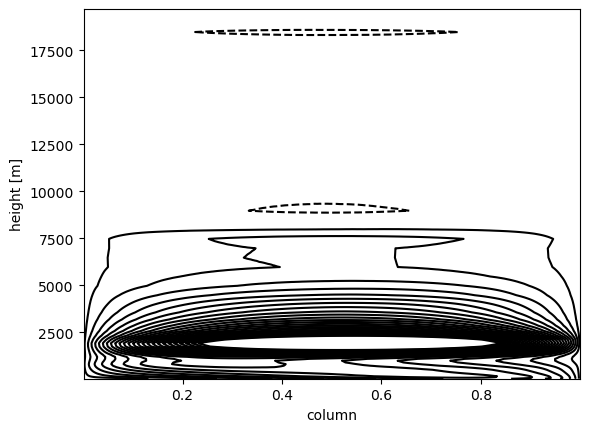

In [10]:
# Quick check the data with plots
#
rho = load_gsam_reference_profiles()['rho']
mf = composite_anomaly_grids['phase8']*rho
circ = mf.cumsum('column')
circ = circ.coarsen({'column': 5}).mean()
circ.plot.contour(levels=np.linspace(-150, 150, 50), colors='black')

# Composites of Different Evolutions